In [21]:
from collections import OrderedDict
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms

In [22]:
def view_classify(img, ps):
    
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [23]:
# Define a transform to normalize the data (Preprocessing)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)


In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

Epoch: 1 | train loss: 0.20028348636900387 | test loss: 0.04963612570356226
Epoch: 2 | train loss: 0.19440375502922883 | test loss: 0.0577193774810753
Epoch: 3 | train loss: 0.18879143021131556 | test loss: 0.060078229207815914
Epoch: 4 | train loss: 0.18355076739198217 | test loss: 0.045021526696964374
Epoch: 5 | train loss: 0.18445020584339897 | test loss: 0.04841222230892869
Epoch: 6 | train loss: 0.17813360271950562 | test loss: 0.04766932822324201
Epoch: 7 | train loss: 0.17177005554288627 | test loss: 0.046952334133644524
Epoch: 8 | train loss: 0.17709615057346723 | test loss: 0.05753791623627216
Epoch: 9 | train loss: 0.17287133745709435 | test loss: 0.05050403400069138
Epoch: 10 | train loss: 0.17126236338540912 | test loss: 0.04487827764579254
Epoch: 11 | train loss: 0.17123525820802898 | test loss: 0.04898079947521798
Epoch: 12 | train loss: 0.17110300097819417 | test loss: 0.04707345040026902
Epoch: 13 | train loss: 0.16550166912972927 | test loss: 0.060319028444868625
Epoch

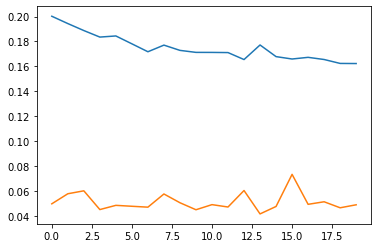

In [27]:
# Training loop

epochs = 20

train_losses = []
test_losses = []

for epoch in range(epochs):

    running_train_loss = 0
    running_test_loss = 0

    for train_imgs, train_labels in iter(trainloader):

        optimizer.zero_grad()

        pred = model.forward(train_imgs)
        pred = pred.squeeze()
        # print(pred.shape, train_labels.shape)
        #train_labels = train_labels.float()
        train_labels = train_labels.long()

        train_loss = criterion(pred, train_labels)

        train_loss.backward()

        optimizer.step()

        running_train_loss += train_loss.item()

    model.eval()
    with torch.no_grad():

        for test_imgs, test_labels in iter(testloader):

            test_pred = model.forward(test_imgs)
            test_pred = test_pred.squeeze()

            #test_labels = test_labels.float()
            test_labels = test_labels.long()


            test_loss = criterion(test_pred, test_labels)

            running_test_loss += test_loss.item()
    model.train()
    
    avg_train_loss  = running_train_loss/len(trainloader)
    avg_test_loss   = running_test_loss/len(testloader)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f'Epoch: {epoch+1} | train loss: {avg_train_loss} | test loss: {avg_test_loss}')


plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')

plt.show()


tensor([[0.0044, 0.7664, 0.0218, 0.0496, 0.0199, 0.0392, 0.0094, 0.0434, 0.0339,
         0.0121]], grad_fn=<SoftmaxBackward0>)


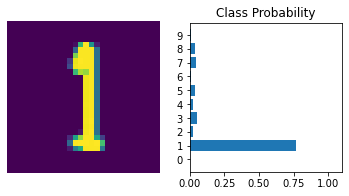

In [28]:
images, labels = next(iter(testloader))
#images.resize_(images.shape[0], 1, 784)
logit = model.forward(images[0,:])
ps = F.softmax(logit, dim =1)
print(ps)
view_classify(images[0].view(1, 28, 28), ps)


In [10]:
# saving model
#torch.save(model, './handrecgn_model.pt') 

### with my handwriting

In [29]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
    ])

tensor([[6.4072e-01, 1.2898e-09, 3.5798e-01, 1.4052e-08, 7.2219e-05, 1.7333e-09,
         1.2270e-03, 3.4872e-07, 3.4464e-08, 4.3870e-07]],
       grad_fn=<SoftmaxBackward0>)


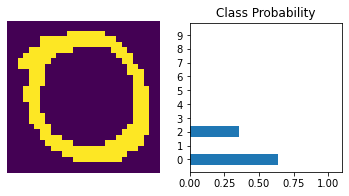

In [30]:
image = Image.open('nums_al/zero.png')
image = trans(image)
#image.resize_(image.shape[0], 1, 784)
image = torch.unsqueeze(image,1)
logit = model.forward(image[0,:])
ps = F.softmax(logit, dim =1)
print(ps)
view_classify(image[0].view(1, 28, 28), ps)